In [1]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc ={'figure.figsize':(15,10)})

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221120'
    }

q = """
    SELECT
        exp_group,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM
        simulator_20221120.feed_actions
    WHERE
        toDate(time) BETWEEN '2022-11-02' AND '2022-11-08'
        AND exp_group in (2, 1)
    GROUP BY
        exp_group,
        user_id
    """


df = pandahouse.read_clickhouse(q, connection=connection)

In [2]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


In [3]:
# группы примерно одинакового размера
    
group_1 = df[df['exp_group']==1].copy()

group_1.shape[0]

10079

In [4]:
group_2 = df[df['exp_group']==2].copy()

group_2.shape[0]

9952

Text(0.5, 1.0, 'CTR distribution')

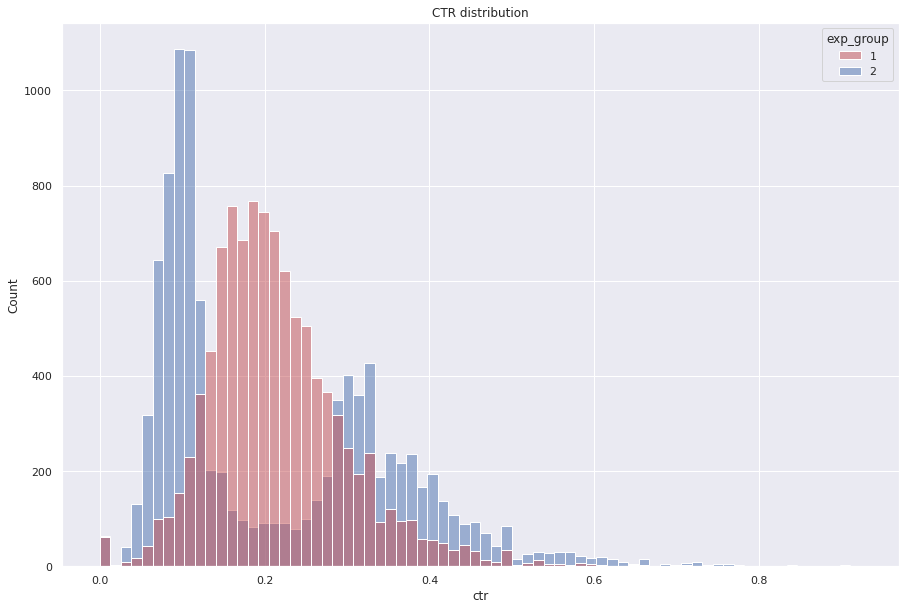

In [5]:
# гистограмма распредления CTR по группам 1 и 2

ax = sns.histplot(df, x = 'ctr', hue = 'exp_group', palette = ['r','b'], kde=False)
ax.set_title('CTR distribution')

## t-test

In [6]:
# t-test

stats.ttest_ind(group_1.ctr,
                group_2.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.709439204127032, pvalue=0.47806231308750413)

p_value > 0.05. t-test показывает что отличий нет

 ## t-test на сглаженном ctr (α=5)

In [10]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

# глобальный CTR группы 1 (А - контроль) и группы 2 (B - тест)
global_ctr_1 = group_1.likes.sum()/group_1.views.sum()
global_ctr_2 = group_2.likes.sum()/group_2.views.sum()

# сглаженные CTR
group_1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group_2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

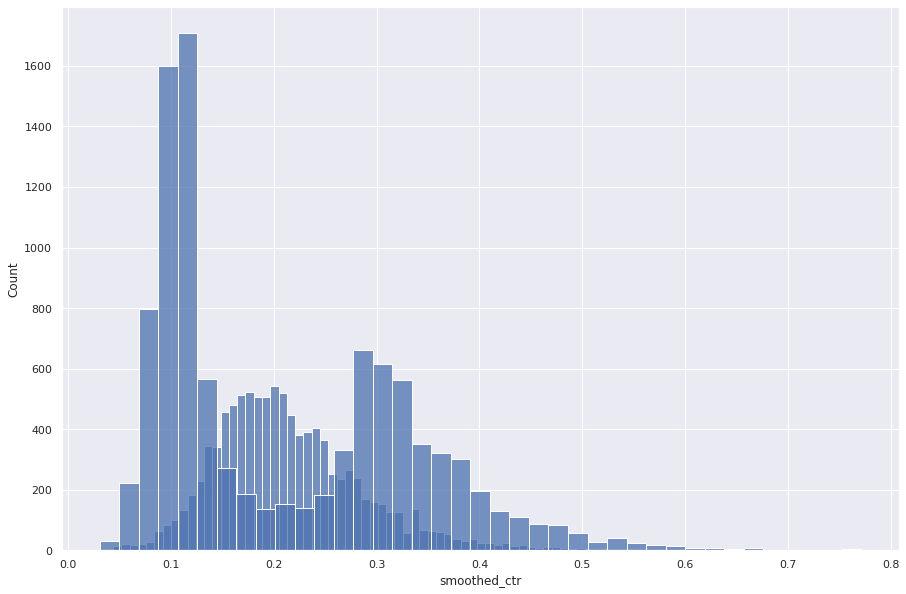

In [11]:
# гистограмма распредления сглаженного CTR по группам 1 и 2

sns.histplot(group_1, x = 'smoothed_ctr', kde=False)
sns.histplot(group_2, x = 'smoothed_ctr', kde=False)

In [14]:
# t-test на сглаженном ctr (α=5)
stats.ttest_ind(group_1.smoothed_ctr,
                group_2.smoothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

p_value < 0.05. t-test показывает что различия есть

 ## bootstrap

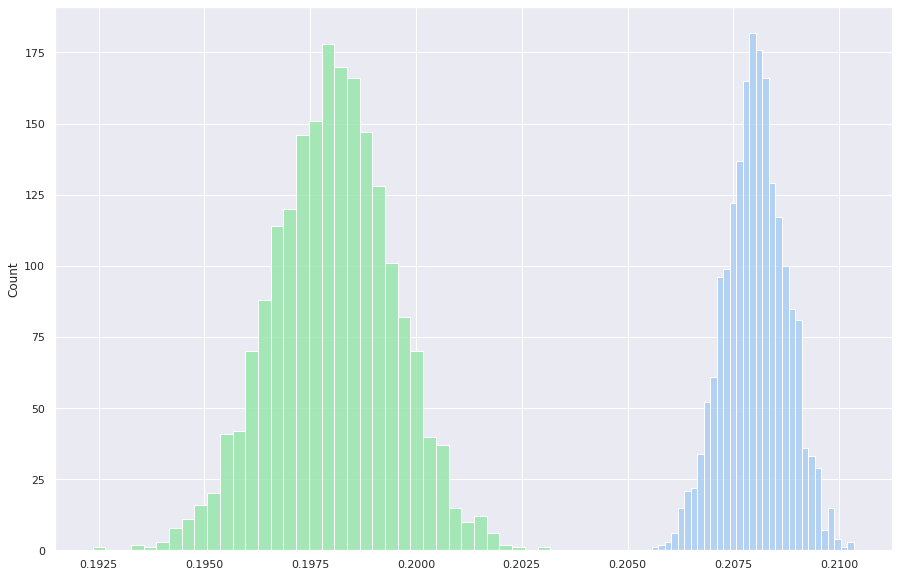

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color = '#a1c9f4')
sns.histplot(ctr2, color = '#8de5a1')

## Бакетное преобразование

In [25]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20221120.feed_actions 
    WHERE toDate(time) BETWEEN '2022-11-02' AND '2022-11-08'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [26]:
df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


In [27]:
#тест Манна-Уитни видит отличие

stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Text(0.5, 1.0, 'Bucket CTR distribution')

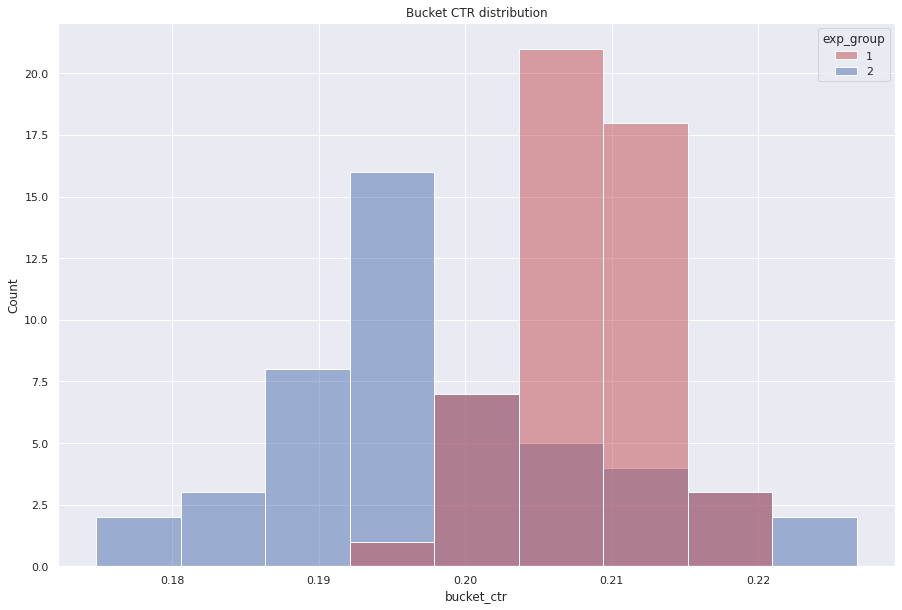

In [31]:
# гистограмма распредления bucket_CTR по группам 1 и 2

ax = sns.histplot(df, x = 'bucket_ctr', hue = 'exp_group', palette = ['r','b'], kde=False)
ax.set_title('Bucket CTR distribution')

Выводы: визуально на графиках и по результатам тестов видим различия между CTR в тестовой и контрольной группах. Bootstrap показывает явные различия в худшую сторону в тестовой группе. Но если посмотреть на гистограмму распределения тестовой группы – видим, что пользователи в этой группе распределились на две подгруппы. Одна группа стала «лайкать» хуже, а другая – заметно лучше. Нужно более детально изучить причины, которые повлияли на это разделение. И найти способ перевести пользователей из «худшей» подгруппы в «лучшую». Раскатывать на всех пользователей результаты теста пока рано. 